In [98]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
import os
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import cv2
%matplotlib inline
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

In [99]:
def load_extracted_features(benign_file='../data/benign_features.txt', malignant_file='../data/malignant_features.txt'):
    benign_df = pd.read_csv(benign_file, sep='\t', header=None)
    malignant_df = pd.read_csv(malignant_file, sep='\t', header=None)
    X_benign_new = benign_df.reset_index().values[:, 1:]
    X_malinant_new = malignant_df.reset_index().values[:, 1:]
    return X_benign_new, X_malinant_new

In [100]:
def get_test_train_data(X_benign, X_malinant, seed, scaled=True):
    X_train_benign, X_test_benign, Y_train_benign, Y_test_benign = train_test_split(X_benign, np.zeros(X_benign.shape[0]), test_size=0.10, random_state=seed)
    X_train_malinant, X_test_malinant, Y_train_malinant, Y_test_malinant = train_test_split(X_malinant, np.ones(X_malinant.shape[0]), test_size=0.10, random_state=seed)
    X_train = np.concatenate((X_train_benign, X_train_malinant), axis=0)
    Y_train = np.concatenate((Y_train_benign, Y_train_malinant), axis=0)
    X_test = np.concatenate((X_test_benign, X_test_malinant), axis=0)
    Y_test = np.concatenate((Y_test_benign, Y_test_malinant), axis=0)
    if scaled:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, Y_train, Y_test
    return (X_train, X_test, Y_train, Y_test)

In [101]:
# Load other features
seed=42
X_benign_new, X_malinant_new = load_extracted_features()
X_train, X_test, Y_train, Y_test = get_test_train_data(X_benign_new, X_malinant_new, seed)
features_names=['area of lesion', 'perimeter of lesion', 'Border irregularity index',   'horizontal_diameter', 'vertical diameter',
                'horizontal asymmetry', 'vertical asymmetry']

In [102]:
seed = 42
num_trees=150
models = {
     'SVM' : svm.SVC(C=10, random_state=42, gamma='scale'),
     'LDA' : LinearDiscriminantAnalysis(),
     'XGBoost' : xgb.XGBClassifier(),
     'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed),
     'LR':LogisticRegression(solver='lbfgs', max_iter=1000)
 }

Model:SVM --> Mean:[0.6148148148148148] , STD:[0.08795808953361421]
Model:LDA --> Mean:[0.5814814814814815] , STD:[0.1425324548510656]
Model:XGBoost --> Mean:[0.537037037037037] , STD:[0.09550960709798242]
Model:RF --> Mean:[0.5888888888888888] , STD:[0.07490277191169142]
Model:LR --> Mean:[0.5851851851851853] , STD:[0.1383817903131067]


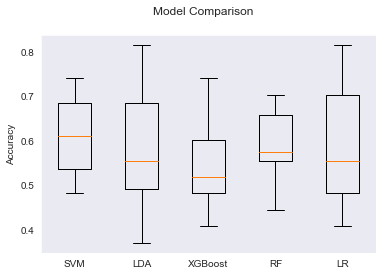

In [103]:
results = []
names =[]
for name, model in models.items():
    cv_results = cross_val_score(model, X_train, Y_train, cv=KFold(n_splits=10), scoring="accuracy", n_jobs=-1)
    print(f"Model:{name} --> Mean:[{cv_results.mean()}] , STD:[{cv_results.std()}]")
    names.append(name)
    results.append(cv_results)
fig = plt.figure()
fig.suptitle(f'Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel("Accuracy")
plt.show()

In [105]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=KFold(n_splits=10), n_jobs=5, scoring="accuracy")   
grid.fit(X_train, Y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    7.8s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [106]:
def plot_roc_auc(Y_test, probs, title='Receiver operating characteristic (Holdout set)'):
    fpr, tpr, _ = roc_curve(Y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [107]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, names=['benign', 'malignant']):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.8666666666666667


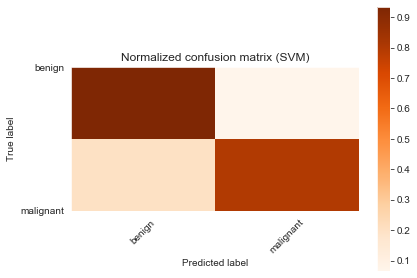

In [108]:
print(grid.best_params_)
print(f"Accuracy: {accuracy_score(Y_test, grid.best_estimator_.predict(X_test))}")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, grid.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (SVM)')
plt.show()
                   

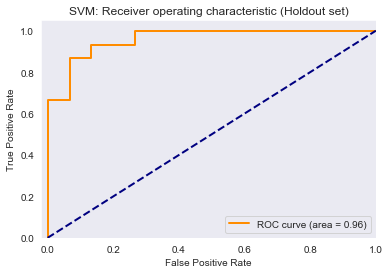

In [109]:
plot_roc_auc(Y_test,grid.decision_function(X_test), 'SVM: Receiver operating characteristic (Holdout set)')

#### Fitting 'Linear kernel' SVM to interpret the model and figure out the feature importance

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    6.1s finished


[ 1.01580614  0.2172878  -0.3342487  -0.53058896  0.07178634  0.53174127
  0.35432831]


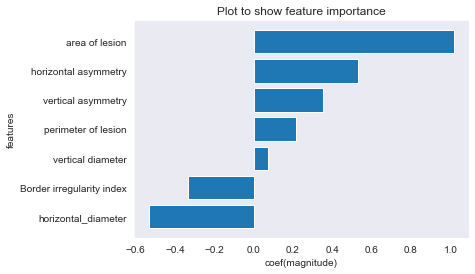

0.8

In [68]:
def f_importances(coef, names):
    imp = coef
    print(imp)
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.ylabel("features")
    plt.xlabel("coef(magnitude)")
    plt.title("Plot to show feature importance")
    plt.show()

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear']}
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=KFold(n_splits=10), n_jobs=5, scoring="accuracy")   
grid.fit(X_train, Y_train)
f_importances(grid.best_estimator_.coef_[0], features_names)
accuracy_score(Y_test, grid.best_estimator_.predict(X_test))

In [77]:
params = {
        'learning_rate':[0.01, 0.02, 0.03, 0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5]
        }
xgb_model = xgb.XGBClassifier(n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
xgb_grid = GridSearchCV(xgb_model, params, refit = True, verbose = 3, cv=KFold(n_splits=10), n_jobs=5, scoring="accuracy")
xgb_grid.fit(X_train, Y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:   22.7s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:   35.4s
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed:   51.4s
[Parallel(n_jobs=5)]: Done 1558 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 1800 out of 1800 | elapsed:  1.4min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=600, n_jobs=1,
                                     nthread=1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=5,
             param_grid={'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.01, 0.02,

[0.1477961  0.16855337 0.08798953 0.13484086 0.16627808 0.12888144
 0.16566059]


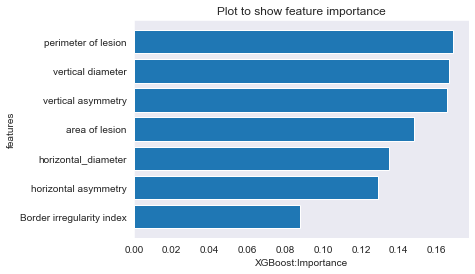

In [78]:
def f_importances(coef, names):
    imp = coef
    print(imp)
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.ylabel("features")
    plt.xlabel("XGBoost:Importance")
    plt.title("Plot to show feature importance")
    plt.show()
f_importances(xgb_grid.best_estimator_.feature_importances_, features_names)

In [81]:
xgb_grid.best_params_

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5}

In [79]:
accuracy_score(Y_test, xgb_grid.best_estimator_.predict(X_test))

0.7666666666666667

[0.1477961  0.16855337 0.08798953 0.13484086 0.16627808 0.12888144
 0.16566059]


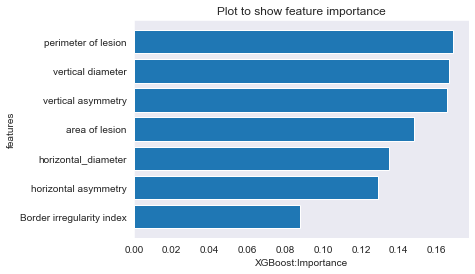

In [80]:
f_importances(xgb_grid.best_estimator_.feature_importances_, features_names)

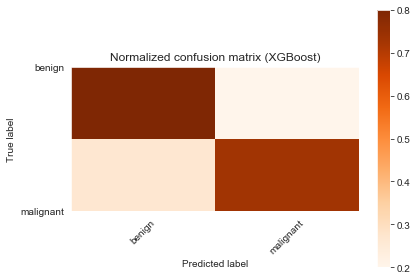

In [83]:
cm = confusion_matrix(Y_test, xgb_grid.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (XGBoost)')
plt.show()

In [84]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, xgb_grid.predict(X_test), target_names=['benign', 'malignant']))

              precision    recall  f1-score   support

      benign       0.75      0.80      0.77        15
   malignant       0.79      0.73      0.76        15

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.77        30
weighted avg       0.77      0.77      0.77        30



In [26]:
params = {
    'shrinkage' : np.arange(0, 1.1, 0.1)
}

lda_grid =  GridSearchCV(LinearDiscriminantAnalysis(solver='lsqr'), params, refit=True, cv=KFold(n_splits=10), verbose=3,scoring="accuracy", n_jobs=5)
lda_grid.fit(X_train, Y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 110 out of 110 | elapsed:    1.8s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='lsqr',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='warn', n_jobs=5,
             param_grid={'shrinkage': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [28]:
accuracy_score(Y_test, lda_grid.best_estimator_.predict(X_test))

0.8

In [59]:
lda_grid.best_estimator_.coef_

array([[0.73557407, 0.72867055, 0.5215595 , 0.70652148, 0.76841578,
        0.62195726, 0.58596732]])

[0.73557407 0.72867055 0.5215595  0.70652148 0.76841578 0.62195726
 0.58596732]


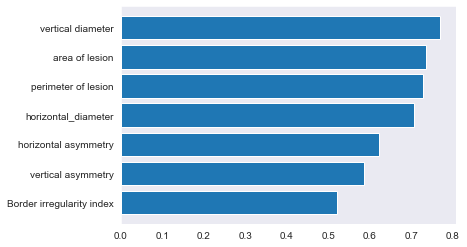

In [60]:
f_importances(lda_grid.best_estimator_.coef_[0], features_names)